# Overview of Logistic Regression | League of Legends Ranked Games

**Game Objective:** Destroy the other team's Nexus. There will be a winning and losing team.

**Background:** Within the two types of games, I will focus on ranked games. It is a **ladder system** and players within each region compete to climb to the top. With that said, this analysis will focus on using a **logistic regression model** and statistical analysis to see which aspects of the game affect the outcome.

**Analysis Objective:** Guide players to **prioritize** and **strategize** around very specific aspects of the game to **maximize the chances of winning**.

**Focus:** There are **numerous factors** that contribute to wins and losses from the **micro aspects** from generating gold, creep scoring, denying experience/gold to enemy laners/junglers to the **macro aspects** from prioritizing first tower for the significant increase in gold, valuable buffs from dragon/baron to name a few. 

This analysis will focus on the **macro aspects** simply because with zero micro skills, complete knowledge of what to focus on in the macro aspects will be useless.

### Import modules

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [6]:
macro_stats = 'macro_stats.csv' # import data
df = pd.read_csv(macro_stats)
df = df.iloc[:, 1:]

df.head()

,t1_inhibitorKills,t1_dragonKills,t1_baronKills,t2_inhibitorKills,t2_dragonKills,t2_baronKills,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,winner
0,1,3,2,0,1,0,2,1,1,1,1,2,1
1,4,2,0,0,0,0,1,1,1,0,1,1,1
2,1,1,1,0,1,0,2,1,1,1,2,0,1
3,2,2,1,0,0,0,1,1,1,1,1,0,1
4,2,3,1,0,1,0,2,1,1,1,1,0,1


## Choosing Predictor Variables

### 1. Remove fields unrelated to the focus

From the previous data wrangling portion of my analysis, I **removed all fields related to micro/miniscual/complex aspects** of the game such as summoner spells, game duration, champion picks and bans.

In [7]:
fields = ['t1_inhibitorKills','t1_dragonKills','t1_baronKills', 
                  't2_inhibitorKills','t2_dragonKills','t2_baronKills', 't2_towerKills',
                    'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
                        'firstDragon', 'firstRiftHerald', 'winner']

### 2. Remove lurking variables

From the remaining fields, tower kills is **directly** related wins. A team needs to destroy **ALL** towers in order to destroy the enemy team's nexus. Thus, I removed 'tower kills' field within our data set.

In [8]:
fields = ['t1_inhibitorKills','t1_dragonKills','t1_baronKills',
                  't2_inhibitorKills','t2_dragonKills','t2_baronKills',
                    'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
                        'firstDragon', 'firstRiftHerald', 'winner']

### 3. Remove duplicate variables

In our dataset, team 1 and 2 inhibitor, dragon and baron kills are shown on each record. Thus, **we don't need both** since using one team's features and labels will give our regression model enough to fit and predict current and future data set (*avoiding overfitting*).

In [9]:
fields = ['t2_inhibitorKills','t2_dragonKills','t2_baronKills',
                    'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
                        'firstDragon', 'firstRiftHerald', 'winner']

## Inspect Correlation Between Reduced Predictor Variables & Target Variable

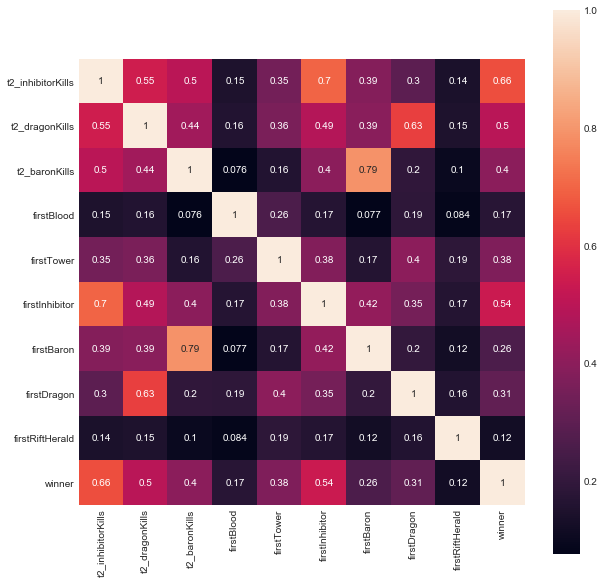

In [11]:
# set up seaborn
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,10))

sns.heatmap(df[fields].corr(),annot=True,square=True) # heatmap of reduced predictor variables and wins

We can speculate the following correlations w/ winning:

    1. Inhibitor Kills | 0.66
    2. Dragon Kills | 0.5
    3. Baron Kills | 0.4
    4. First Blood | 0.17
    5. First Tower | 0.38
    6. First Inhibitor | 0.54
    7. First Baron | 0.26
    8. First Dragon | 0.31
    9. First Rift Herald | 0.12
    

Although there is **high correlation** between Inhibitor Kills, Dragon Kills and Baron Kills with winning, there is a relatively **high occurence of multicollinearity** with its first occurances. 

## Multicollinearity

### Inhibitor Kills

Inhibitor Kills have a 0.7 correlation w/ First Inhibitor Kills which **makes sense** since there are three inhibitors on each team's side and once a team destroys the first inhibitor, **lots of advantages open up** for them such as spawning superminions, side lane pressure, etc. and thus, makes it easier for the team to destroy the other two inhibitors. 

### Dragon Kills

Dragon Kills have a 0.63 correlation w/ First Dragon kills which **is expected** since dragon spawns at two minutes and thirty seconds into the game and respawns every seven minutes and thus, w/ a mean duration of 25 minutes per game (*as explored through our EDA*), the **expected value of dragon kills will be lower** and thus, relatively correlated w/ First Dragon Kills.

### Baron Kills

*As explored through our EDA portion of duration analysis*, the mean and median of duration of ranked games is **roughly 25 minutes**. Baron spawns at 20 minutes and respawns every seven minutes once slain. Furthermore, teams are *usually* not strong enough to slay Baron at 20 minutes. With this assumption, the maximum number of barons killed a game is approximately 2 and thus, explains the  0.79 correlation w/ first baron kills.

##### Conclusion: Muticollinearity

Thus, we will want to **exclude** the first occurances of inhibitor, dragon and baron kills within our regression model because the **total number of kills of each objective has a stronger correlation w/ winning** and **we want each predictor variable to explain the variance of the data from different directions**. Furthermore, we want to **remove the First Rift Herald and First Blood Kill** from the predictor variables because they both have a **relatively weak correlation w/ winning**.

In [34]:
fields = ['t2_inhibitorKills','t2_dragonKills', # Update fields
          't2_baronKills', 'firstTower']

## Train Logistic Regression Model w/ GridSearch

In [69]:
# import SciKit Learn Modules
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Specify predictor and target variables
predict_v = df[fields]
target_v = df[['winner']]

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(predict_v.values, target_v.values,
                                                  test_size=0.2, random_state=5)

# Reshape ylr and ytestlr
c, r = ylr.shape
ylr = ylr.reshape(c,)
c, r = ytestlr.shape
ytestlr = ytestlr.reshape(c,)

In [70]:
# Implement GridSearch to our classfier w/ the best parameter
clf = LogisticRegression()
parameters = {"C": [0.0001, 0.001, .005, 0.1, 1, 10, 100]}
model = GridSearchCV(clf, param_grid=parameters, cv=5, scoring="accuracy")
model.fit(Xlr, ylr)
model.best_estimator_

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
# Tune Classifier w/ Best Classifier, Fit Model, Predict, and Evaluate
clf = LogisticRegression(C=0.005)
clf.fit(Xlr, ylr)
ypred = clf.predict(Xtestlr)
accuracy_score(ypred, ytestlr)

0.8888133618178287

#### Implementing our model w/ the test data resulted in 88.88% accuracy which is quite strong.

## Evaluating Scores

In [73]:
from sklearn.metrics import classification_report
print(classification_report(ytestlr, ypred))

             precision    recall  f1-score   support

          1       0.88      0.90      0.89      5183
          2       0.90      0.88      0.89      5115

avg / total       0.89      0.89      0.89     10298



Our model's **precision and recall** are *both* relatively high at an average of .89 which is quite strong which means that our model is not only correclty classifies the data points in terms of all records *(recall)*, but is accurate in each prediction *(precision)*.

The **harmonic mean (F1-score)** is also at .89 since it is the weighted average of both precision and recall.

## Conclusion

In conclusion, inhibitor, dragon, baron and first tower kills are **relatively strong indicators** for the winning team. Strategies and team compositions that focus on these objectives open up hidden advantages not captured within the data that statistically increase the chances of winning the game. 

With **first tower** kills being extremely significant, Azubu Blaze back in 2012 focused on **not only pressuring and destroying first towers**, but capitalizing on this advantage by **splitting open the map, aiding the mid lane if behind and opening up the entire jungle on the bot side** -- leaving it completely vulnerable to vision and invades. During this time, North America and Europe were focused on **leaving the first towers** up to take advantage of lane leads but at the MLG 2012, Azubu Blaze took first with this strategy.

As for **dragon kills** and **baron kills**, creating a team composition of choosing champions in ranked games that have **consistent damage** to take down these large health monsters OR strong abilities that **secure dragon and barons** such as Chogath or Nunu can be advantageous to master as champs to bring to the ranked games.

Lastly, with **inhibitor kills**, it's known that superminions spawn but even further, the **map splits open** and the enemy team needs to continue to defend their base while the enemy team might be **contesting baron or elder drake** which is also quite significant as mentioned above. With three inhibitors down, it's extremely difficult to defend objectives and your base all while fighting the enemy team. 

With this said, there are numerous of factors **as well as** hidden effects of these objectives being destroyed that dramatically can increase the chances of winning. It's **very difficult to capture the data** but it's quite apparent from exploring the data, applying inferential statistics and implementing this model, that there are adjustments and tweaks that you can implement into your practice and strategy going into the ranked ladders to increase your chances of winning.

And as mentioned in the very beginning of exploring the data, Riot Games is constantly changing the game to balance champions/items, to increase the pace so that it's more entertaining for viewers, etc. Thus, this is a **VERY** general assumption and model that can be grouped by each season and region to get more in depth insights. There is a plethora of perspectives, angles and aspects of the game to analyze and I'm extremely excited for the journey.
